<a href="https://colab.research.google.com/github/Davis-Tony/DS-Unit-2-Linear-Models/blob/master/Davis_Tony_LS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

###Train/Test Split

In [3]:
#df review
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
#Checking mix and max of 'created' column
print(df['created'].min())
df['created'].max()

2016-04-01 22:12:41


'2016-06-29 21:41:47'

In [5]:
#Creating train and test dataframes
train =  df[df['created'] < '2016-06-01']
test = df[df['created'] >= '2016-06-01']


In [6]:
#Verifying correct splits in new dataframes
print(train['created'].min())
train['created'].max()

2016-04-01 22:12:41


'2016-05-31 23:10:48'

In [7]:
#Verifying test dataframe
print(test['created'].min())
test['created'].max()

2016-06-01 01:10:37


'2016-06-29 21:41:47'

###Engineering Two New Features

In [8]:
#Recalling dataframe
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
df.shape

(48817, 34)

In [10]:
#Engineering First Feature
#First will be total number of rooms
train['total_rooms'] = df['bedrooms'] + df['bathrooms']
test['total_rooms'] = df['bedrooms'] + df['bathrooms']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [11]:
#Engineering second feature
#Bathroom to bedroom ratio
train['bath_bed_ratio'] = df['bathrooms'] / df['bedrooms']
test['bath_bed_ratio'] = df['bathrooms'] / df['bedrooms']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [12]:
#Checking new features
train.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,total_rooms,bath_bed_ratio
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1.00
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1.00
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,0.25
5,2.0,4,2016-04-19 04:24:47,,West 18th Street,40.7429,-74.0028,7995,350 West 18th Street,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,0.50
6,1.0,2,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,40.8012,-73.9660,3600,210 West 107th Street,low,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,0.50


###Linear Regression with Two Features

What is the average price of an apartment for rent in NYC in April and May of 2016?

In [16]:
#Recalling training data
train.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,total_rooms,bath_bed_ratio
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1.00
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1.00
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,0.25
5,2.0,4,2016-04-19 04:24:47,,West 18th Street,40.7429,-74.0028,7995,350 West 18th Street,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,0.50
6,1.0,2,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,40.8012,-73.9660,3600,210 West 107th Street,low,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,0.50


In [14]:
#The baseline is the mean of the single variable.. in this case, price of apartment
print(df['price'].mean())

3579.5852469426636


In [27]:
#Arranging Feature Matrices
features = ['bedrooms', 'latitude']

X_train = train[features]
X_test = test[features]

X_train.head()

,bedrooms,latitude
2,1,40.7388
3,1,40.7539
4,4,40.8241
5,4,40.7429
6,2,40.8012


In [28]:
#Arranging y vector
target = ['price']

y_train = train[target]
y_test = test[target]

y_train.head()

,price
2,2850
3,3275
4,3350
5,7995
6,3600


In [21]:
#Importing the Estimator
from sklearn.linear_model import LinearRegression

In [22]:
#Instantiate this class
model = LinearRegression()

In [29]:
#Fit the Model
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
#Applying the Model for Predictions

y_pred = model.predict(X_train)

In [ ]:
#Plotting Data
import plotly.express as px

px.scatter_3d(
    train,
    x='bedrooms',
    y='latitude',
    z='price',
    text='price',
    title='Apartment Price in NYC'
)

In [31]:
#Plotting Plane of Best Fit
import itertools
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression

def regression_3d(df, x, y, z, num=100, **kwargs):
    """
    Visualize linear regression in 3D: 2 features + 1 target
    
    df : Pandas DataFrame
    x : string, feature 1 column in df
    y : string, feature 2 column in df
    z : string, target column in df
    num : integer, number of quantiles for each feature
    """
    
    # Plot data
    fig = px.scatter_3d(df, x, y, z, **kwargs)
    
    # Fit Linear Regression
    features = [x, y]
    target = z
    model = LinearRegression()
    model.fit(df[features], df[target])    
    
    # Define grid of coordinates in the feature space
    xmin, xmax = df[x].min(), df[x].max()
    ymin, ymax = df[y].min(), df[y].max()
    xcoords = np.linspace(xmin, xmax, num)
    ycoords = np.linspace(ymin, ymax, num)
    coords = list(itertools.product(xcoords, ycoords))
    
    # Make predictions for the grid
    predictions = model.predict(coords)
    Z = predictions.reshape(num, num).T
    
    # Plot predictions as a 3D surface (plane)
    fig.add_trace(go.Surface(x=xcoords, y=ycoords, z=Z))
    
    return fig

In [34]:
regression_3d(
    train,
    x='bedrooms', 
    y='latitude', 
    z='price', 
    text='price', 
    title='Apartment Cost in NYC'
)

###Get the Coefficient and Intecept

In [40]:
#Displaying Intercept and Coefficient
print('The Intercept is', model.intercept_)

#coefficients = pd.Series(model.coef_)

print('The coefficients are ',model.coef_)



The Intercept is [79587.31500843]
The coefficients are  [[  855.81468397 -1897.38137042]]


This shows a positive relationship between number of bedrooms and price and a negative one between price and the latitude of the address.

###Get Regression Metrics

In [59]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def squared_errors(df, features, target, m, b):
    """
    Visualize linear regression, with squared errors,
    in 2D: 1 feature + 1 target.
    
    Use the m & b parameters to "fit the model" manually.
    
    df : Pandas DataFrame
    feature : string, feature column in df
    target : string, target column in df
    m : numeric, slope for linear equation
    b : numeric, intercept for linear requation
    """
    
    # Plot data
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()
    df.plot.scatter(features, target, ax=ax)
    
    # Make predictions
    x = df[features]
    y = df[target]
    y_pred = m*x + b
    
    # Plot predictions
    ax.plot(x, y_pred)
    
    # Plot squared errors
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    scale = (xmax-xmin)/(ymax-ymin)
    for x, y1, y2 in zip(x, y, y_pred):
        bottom_left = (x, min(y1, y2))
        height = abs(y1 - y2)
        width = height * scale
        ax.add_patch(Rectangle(xy=bottom_left, width=width, height=height, alpha=0.1))
    
    # Print regression metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Error:', mae)
    print('R^2:', r2)

ValueError: ignored

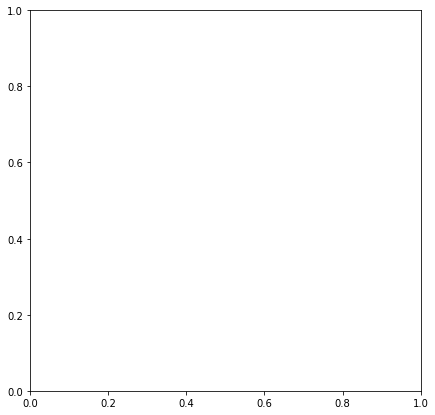

In [60]:
squared_errors(train, features, target, m=0, b=y_train.mean())